In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
import wandb
import torch.nn as nn
import scipy.io
import numpy as np

In [ ]:
wandb.login()
wandb.init(project="CV_A1_Q1_3", entity="iiitd")

In [ ]:
train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
download_url(train_url, '.')

Using downloaded and verified file: ./train_32x32.mat


In [ ]:
class DataSet:
  def __init__(self,path,transform = None):
    self.raw = scipy.io.loadmat(path)
    self.X = self.raw['X'].transpose()
    self.y = self.raw['y']
    self.transform = transform
  
  def __getitem__(self,index):
    img = np.transpose(self.X[index], (1, 2, 0))
    
    label = self.y[index]
    if label[0] ==10:
      label = [0]
    return img , label[0]

  def __len__(self):
    return self.y.shape[0]


In [ ]:
class IDataSet:
  def __init__(self,data,transform ):
    self.data = data
    self.transform = transform

  def __getitem__(self,index):
    temp = self.data[index]
    img = self.transform (temp[0] )
    label = temp[1]
    return img , label

  def __len__(self):
    return len(self.data)


In [ ]:
#data = torchvision.datasets.SVHN('.',download=True,transform=trans)

train_path = r'/content/train_32x32.mat'
#test_path = r'/content/test_32x32.mat'

#test = DataSet(test_path,trans)

In [ ]:
data = DataSet(train_path)

In [ ]:
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    
])



In [ ]:
trans_aug = tt.Compose([
    tt.ToTensor(),tt.RandomGrayscale(),tt.RandomVerticalFlip(),tt.RandomHorizontalFlip(),tt.RandomRotation(degrees=20),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    
])



In [ ]:
batch =32

In [ ]:
test_size = int(len(data)*0.1)
val_size = int(len(data)*0.2)
train_size = len(data)-test_size-val_size

train_ds, val_ds ,test_ds = random_split(data, [train_size,val_size, test_size])

print(len(train_ds), len(val_ds),len(test_ds))

51281 14651 7325


In [ ]:

train_dl = DataLoader( IDataSet(train_ds,trans_aug),batch, shuffle=True)
val_dl = DataLoader( IDataSet(val_ds,trans),batch, shuffle=True)
test_dl = DataLoader( IDataSet(test_ds,trans),batch, shuffle=True)


torch.Size([3, 224, 224])
tensor([4, 2, 6, 6, 2, 7, 9, 6, 0, 2, 2, 8, 2, 1, 4, 8, 8, 2, 2, 4, 1, 1, 6, 7,
        6, 6, 1, 1, 0, 4, 7, 1])


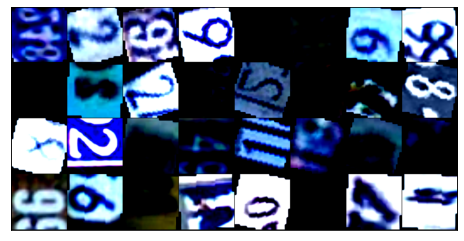

In [ ]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, label in dl:
        print(images[0].shape)
        print(label[:64])
        show_images(images, nmax)
        break
show_batch(train_dl,64)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self ):
    super().__init__()
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(in_features=512,out_features=10)
    self.network =model
  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [ ]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs):
  history = []
  optimizer =  optim(model.parameters(),lr=lr)
  
  for epoch in range(epochs):
    train_loss = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      
      train_loss.append(loss.item())
      optimizer.step()
      
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [ ]:

cmodel = Model()

cmodel = to_device(cmodel,'cuda')
lr = 0.008
optimizer= torch.optim.SGD
epochs=10
wandb.config = {'lr':lr,'optimuzer':'Adam','epochs':epochs,'batch_size':batch}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
wandb.watch(cmodel)
from tqdm.notebook import tqdm
history=fit(train_dl,val_dl,cmodel,lr,optimizer,epochs)

  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :1, training loss: 1.0432982850989474, validation loss: 0.5740968672859617, accuracy: 0.7949569225311279


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :2, training loss: 0.5969257349995473, validation loss: 0.48177674673009646, accuracy: 0.8219336867332458


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :3, training loss: 0.5245478553784615, validation loss: 0.460681581341023, accuracy: 0.8308719992637634


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :4, training loss: 0.4815541233725646, validation loss: 0.4222509861643137, accuracy: 0.8452990651130676


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :5, training loss: 0.45849222639669723, validation loss: 0.41017908341857284, accuracy: 0.8412305116653442


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :6, training loss: 0.4351694586123813, validation loss: 0.3932115032976111, accuracy: 0.8530092239379883


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :7, training loss: 0.4124050758458344, validation loss: 0.3594064417754719, accuracy: 0.8730390071868896


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :8, training loss: 0.3998577568868288, validation loss: 0.3747714890419266, accuracy: 0.8616569638252258


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :9, training loss: 0.3834910502172751, validation loss: 0.3763021702377947, accuracy: 0.8695465326309204


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :10, training loss: 0.37337138306254236, validation loss: 0.3700828942669531, accuracy: 0.8660112023353577


In [ ]:
torch.save(cmodel.state_dict(),"model.pth")
artifact  = wandb.Artifact('model',type = 'model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  cmodel.eval()
  acc=0
  f1=0
  list_label = []
  list_pred = []
  

  for num,(img,label) in enumerate(test_dl):
    outputs = cmodel(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().tolist(),label.cpu().clone().tolist())
    
    list_label+=labelx
    list_pred+=predx
  f1 =f1_score(list_label,list_pred,average='macro')
  acc =accuracy_score(list_label,list_pred)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                       y_true=list_label, preds=list_pred,
                     )})
  wandb.log({'f1_score':f1,'accuracy_score':acc})
  return f'f1 Score: {f1}', f'Accuracy: {acc}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.8284500354187466', 'Accuracy: 0.86580204778157')


In [ ]:
wandb.finish()

accuracy,▁▃▄▆▅▆█▇█▇
accuracy_score,▁
epoch,▁▂▃▃▄▅▆▆▇█
f1_score,▁
training loss,█▃▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▃▂▁▂▂▁
accuracy,0.86601
accuracy_score,0.8658
epoch,10
f1_score,0.82845
training loss,0.37337
